In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

file_path = "C:/ML/python/data/cps_00128.csv.gz"
data = pd.read_csv(file_path, compression='gzip')

data.columns


sampling_fraction = 0.1
random_state = 42

sampled_df = data.sample(frac=sampling_fraction, random_state=random_state)
features = ["WSREGSHFT","AGE", "PAIDHOUR", "EARNWEEK", "HOURWAGE", "UHRSWORK1", "EDUC", "OCC1990", "EARNWT"]


df = sampled_df[features]

df.info()

df.isna().sum()

df['EARNWEEK'] * df['EARNWT']
df['PAIDHOUR'].describe()

df = df[
        (df['AGE'].between(16,64)) & df['PAIDHOUR'].between(1,2) &
        df["WSREGSHFT"].between(1,2)]



valid_conditions = (df['EARNWEEK'] > 0) & (df['EARNWEEK'] < 9999.99) & (df['UHRSWORK1'] > 0) & (df['UHRSWORK1'] < 997)

hourly_wage_condition = (df['PAIDHOUR'] == 2) & (df['HOURWAGE'] > 0) & (df['HOURWAGE'] < 99)

df.loc[valid_conditions & hourly_wage_condition, 'HOURWAGE'] = df.loc[valid_conditions & hourly_wage_condition, 'HOURWAGE']

not_paid_hour_condition = (df['PAIDHOUR'] == 1)


df.loc[valid_conditions & not_paid_hour_condition, 'HOURWAGE'] = df.loc[valid_conditions & not_paid_hour_condition, 'EARNWEEK'] / df.loc[valid_conditions & not_paid_hour_condition, 'UHRSWORK1']

df['HOURWAGE'] = df['HOURWAGE'].clip(lower=0, upper=997)

df.isna().sum()

df['WSREGSHFT'] = [1 if X == 1 else 0 for X in df['WSREGSHFT']]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 291565 entries, 2258686 to 321084
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WSREGSHFT  13751 non-null   float64
 1   AGE        291565 non-null  int64  
 2   PAIDHOUR   291565 non-null  int64  
 3   EARNWEEK   291565 non-null  float64
 4   HOURWAGE   291565 non-null  float64
 5   UHRSWORK1  291565 non-null  int64  
 6   EDUC       291565 non-null  int64  
 7   OCC1990    291565 non-null  int64  
 8   EARNWT     291565 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 22.2 MB


In [2]:
less_than_high_school = (df['EDUC'] <= 60)
high_school = (df['EDUC'] >= 70) & (df['EDUC'] <= 73)
some_college = (df['EDUC'] >= 80) & (df['EDUC'] <= 100)
college = (df['EDUC'] >= 110)


df.loc[less_than_high_school, 'EDUC'] = 'Less than High School'
df.loc[high_school, 'EDUC'] = 'High School'
df.loc[some_college, 'EDUC'] = 'Some College'
df.loc[college, 'EDUC'] = 'College'


df.info()


#### age groups


bins_age = [16,21,30,40,50,64]  
labels_age = ['16-20','21-30','31-40','41-50','51-64']  
df['age_group'] = pd.cut(df['AGE'], bins=bins_age, labels=labels_age, right=False) 


print(df['age_group'].value_counts())



from tabulate import tabulate





#fraction of workers in each wage group with irregular shifts education


total_workers_education = df.groupby('EDUC').size().reset_index(name='Total Workers')


education_group_irregular_shift = df[df['WSREGSHFT'] == 1].groupby('EDUC').size().reset_index(name='Irregular Shift Workers')


merged_df = pd.merge(total_workers_education, education_group_irregular_shift, on='EDUC', how='left')


merged_df['Fraction with Irregular Shift'] = merged_df['Irregular Shift Workers'] / merged_df['Total Workers']


education_group_df = merged_df.rename(columns={'Total Workers': 'Total Workers', 'Irregular Shift Workers': 'Irregular Shift Workers'})


education_group_df = education_group_df[['EDUC', 'Total Workers', 'Irregular Shift Workers', 'Fraction with Irregular Shift']]


print(tabulate(education_group_df, headers='keys', tablefmt='grid'))


#age group irregular shifts


age_group_counts = df['age_group'].value_counts().reset_index()
age_group_counts.columns = ['Age Group', 'Total Workers']


irregular_shift_counts = df[df['WSREGSHFT'] == 1]['age_group'].value_counts().reset_index()
irregular_shift_counts.columns = ['Age Group', 'Irregular Shift Workers']


merged_counts = pd.merge(age_group_counts, irregular_shift_counts, on='Age Group')


merged_counts['Fraction with Irregular Shift'] = merged_counts['Irregular Shift Workers'] / merged_counts['Total Workers']


age_group_data = merged_counts[['Age Group', 'Fraction with Irregular Shift']].values.tolist()


headers = ['Age Group', 'Fraction with Irregular Shift']


print(tabulate(age_group_data, headers=headers, tablefmt='grid'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 13153 to 63888
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   WSREGSHFT  1296 non-null   int64  
 1   AGE        1296 non-null   int64  
 2   PAIDHOUR   1296 non-null   int64  
 3   EARNWEEK   1296 non-null   float64
 4   HOURWAGE   1296 non-null   float64
 5   UHRSWORK1  1296 non-null   int64  
 6   EDUC       1296 non-null   object 
 7   OCC1990    1296 non-null   int64  
 8   EARNWT     1296 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 101.2+ KB
41-50    359
51-64    321
31-40    281
21-30    240
16-20     91
Name: age_group, dtype: int64
+----+-----------------------+-----------------+---------------------------+---------------------------------+
|    | EDUC                  |   Total Workers |   Irregular Shift Workers |   Fraction with Irregular Shift |
+====+=======================+=================+====================

In [3]:
regular_shift_mean_hourly_wage = df[df['WSREGSHFT'] == 0]['HOURWAGE'].mean()
irregular_shift_mean_hourly_wage = df[df['WSREGSHFT'] == 1]['HOURWAGE'].mean()


mean_hourly_wage_df = pd.DataFrame({
    'Shift Type': ['Regular Shift', 'Irregular Shift'],
    'Mean Hourly Wage': [regular_shift_mean_hourly_wage, irregular_shift_mean_hourly_wage]
})


mean_hourly_wage = df.groupby(['WSREGSHFT', 'EDUC'])['HOURWAGE'].mean().reset_index()


mean_hourly_wage_pivot = mean_hourly_wage.pivot(index='EDUC', columns='WSREGSHFT', values='HOURWAGE')
mean_hourly_wage_pivot.columns = ['Regular Shift Mean Hourly Wage', 'Irregular Shift Mean Hourly Wage']
mean_hourly_wage_pivot.reset_index(inplace=True)


education_group_df = pd.merge(education_group_df, mean_hourly_wage_pivot, on='EDUC', how='left')

print(tabulate(mean_hourly_wage_df, headers='keys', tablefmt='grid'))


print(tabulate(education_group_df, headers='keys', tablefmt='pretty'))


## occupation groups irregular shifts

occupations = {
    'Registered Nurse': 95,
    'Cashier': 276,
    'Cooks': 436,
    'Truck Drivers': 804
}

occupation_data = []
for occupation, code in occupations.items():
    occupation_df = df[df['OCC1990'] == code]
    total_workers = len(occupation_df)
    regular_shift_mean_hourly_wage = occupation_df[occupation_df['WSREGSHFT'] == 0]['HOURWAGE'].mean()
    irregular_shift_mean_hourly_wage = occupation_df[occupation_df['WSREGSHFT'] == 1]['HOURWAGE'].mean()
    irregular_shift_workers = len(occupation_df[occupation_df['WSREGSHFT'] == 1])
    occupation_data.append([occupation, total_workers, irregular_shift_workers])

occupation_df = pd.DataFrame(occupation_data, columns=['Occupation', 'Total Workers', 'Irregular Shift Workers'])

print(tabulate(occupation_df, headers='keys', tablefmt='pretty'))

+----+-----------------+--------------------+
|    | Shift Type      |   Mean Hourly Wage |
+====+=================+====================+
|  0 | Regular Shift   |            41.0151 |
+----+-----------------+--------------------+
|  1 | Irregular Shift |            39.879  |
+----+-----------------+--------------------+
+---+-----------------------+---------------+-------------------------+-------------------------------+--------------------------------+----------------------------------+
|   |         EDUC          | Total Workers | Irregular Shift Workers | Fraction with Irregular Shift | Regular Shift Mean Hourly Wage | Irregular Shift Mean Hourly Wage |
+---+-----------------------+---------------+-------------------------+-------------------------------+--------------------------------+----------------------------------+
| 0 |        College        |      376      |           36            |      0.09574468085106383      |       62.418032250359516       |        128.51901296296296

+---+------------------+---------------+-------------------------+----------------------------+------------------------------+
|   |    Occupation    | Total Workers | Irregular Shift Workers | Mean Hourly Wage (Regular) | Mean Hourly Wage (Irregular) |
+---+------------------+---------------+-------------------------+----------------------------+------------------------------+
| 0 | Registered Nurse |      36       |            9            |     25.27662037037037      |      24.267441520467838      |
| 1 |     Cashier      |      28       |           14            |     6.914285714285714      |      7.971428571428571       |
| 2 |      Cooks       |      40       |           15            |     10.991287999999999     |      8.126666666666667       |
| 3 |  Truck Drivers   |      30       |           10            |     112.75506176470587     |      15.042096428571426      |
+---+------------------+---------------+-------------------------+----------------------------+----------------

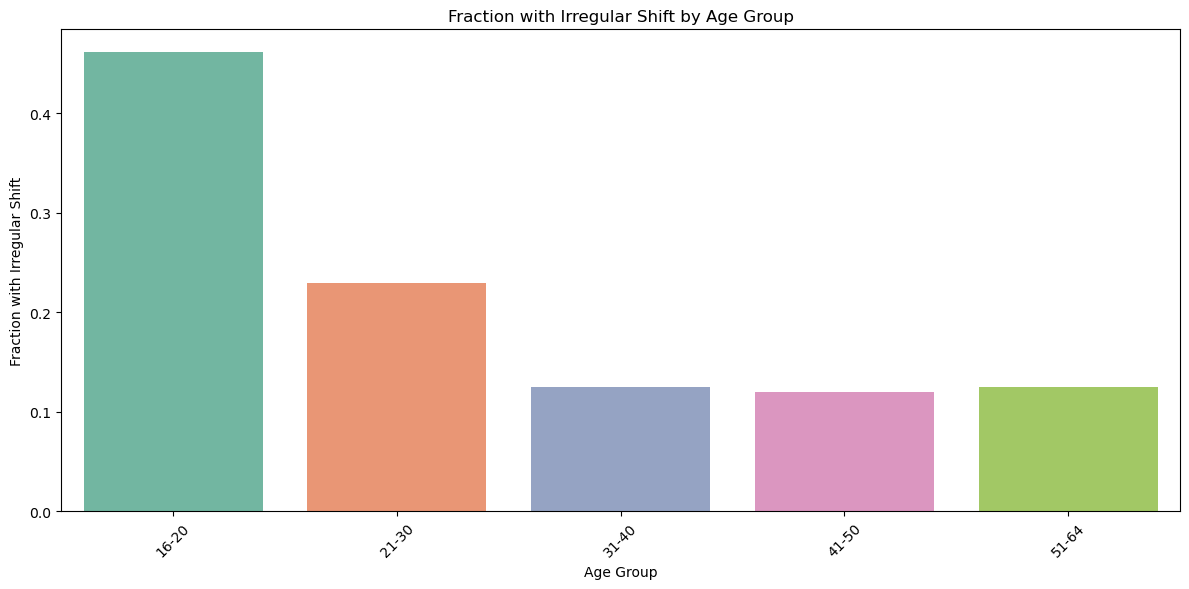

In [4]:
occupation_data = []
for occupation, code in occupations.items():
    occupation_df = df[df['OCC1990'] == code]
    total_workers = len(occupation_df)
    irregular_shift_workers = len(occupation_df[occupation_df['WSREGSHFT'] == 1])
    regular_shift_mean_hourly_wage = occupation_df[occupation_df['WSREGSHFT'] == 0]['HOURWAGE'].mean()
    irregular_shift_mean_hourly_wage = occupation_df[occupation_df['WSREGSHFT'] == 1]['HOURWAGE'].mean()
    occupation_data.append([occupation, total_workers, irregular_shift_workers, regular_shift_mean_hourly_wage, irregular_shift_mean_hourly_wage])


occupation_df = pd.DataFrame(occupation_data, columns=['Occupation', 'Total Workers', 'Irregular Shift Workers', 'Mean Hourly Wage (Regular)', 'Mean Hourly Wage (Irregular)'])


print(tabulate(occupation_df, headers='keys', tablefmt='pretty'))


# Discussion Questions


import seaborn as sns
import matplotlib.pyplot as plt



#irregular shifts across age groups

def age_groups_shifts(df):
    age_group_counts = df.groupby('age_group')['WSREGSHFT'].mean().reset_index()
    

    plt.figure(figsize=(12,6))
    sns.barplot(x='age_group', y='WSREGSHFT', data=age_group_counts, palette='Set2')
    

    plt.xlabel('Age Group')
    plt.ylabel('Fraction with Irregular Shift')
    plt.title('Fraction with Irregular Shift by Age Group')
    

    plt.xticks(rotation=45)
    

    plt.tight_layout()
    plt.show()

    
age_groups_shifts(df)

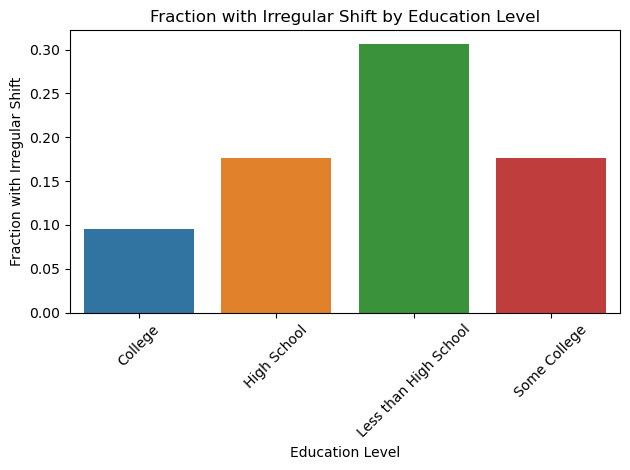

In [5]:
def education_groups_shifts(education_group_df):
    sns.barplot(x='EDUC', y='Fraction with Irregular Shift', data=education_group_df)
    plt.xlabel('Education Level')
    plt.ylabel('Fraction with Irregular Shift')
    plt.title('Fraction with Irregular Shift by Education Level')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

education_groups_shifts(education_group_df)

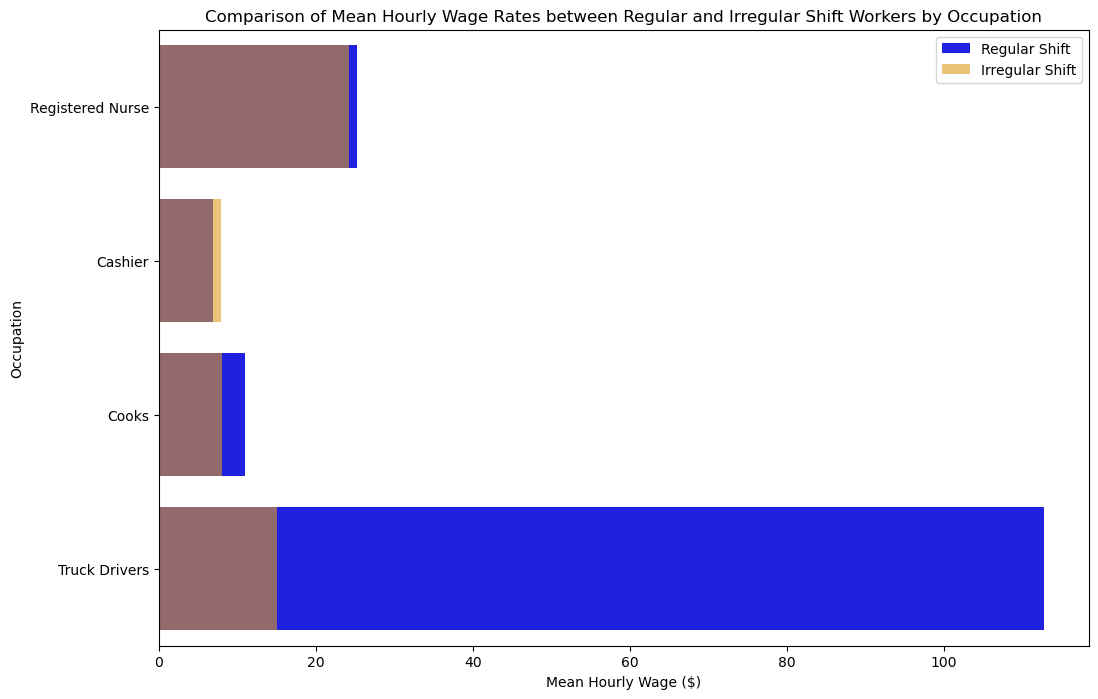

Mean Hourly Wage (Regular Shift): $38.98
Mean Hourly Wage (Irregular Shift): $13.85
Compensating Wage Differential: $25.13


In [6]:
def compare_hourly_wage(occupation_df):
    plt.figure(figsize=(12,8))
    sns.barplot(x='Mean Hourly Wage (Regular)', y='Occupation', data=occupation_df, color='blue', label='Regular Shift')
    sns.barplot(x='Mean Hourly Wage (Irregular)', y='Occupation', data=occupation_df, color='orange', label='Irregular Shift', alpha=0.6)
    plt.xlabel('Mean Hourly Wage ($)')
    plt.ylabel('Occupation')
    plt.title('Comparison of Mean Hourly Wage Rates between Regular and Irregular Shift Workers by Occupation')
    plt.legend()
    plt.show()

    regular_shift_mean_hourly_wage = occupation_df['Mean Hourly Wage (Regular)'].mean()
    irregular_shift_mean_hourly_wage = occupation_df['Mean Hourly Wage (Irregular)'].mean()
    wage_differential = regular_shift_mean_hourly_wage - irregular_shift_mean_hourly_wage

    print(f"Mean Hourly Wage (Regular Shift): ${regular_shift_mean_hourly_wage:.2f}")
    print(f"Mean Hourly Wage (Irregular Shift): ${irregular_shift_mean_hourly_wage:.2f}")
    print(f"Compensating Wage Differential: ${wage_differential:.2f}")

compare_hourly_wage(occupation_df)



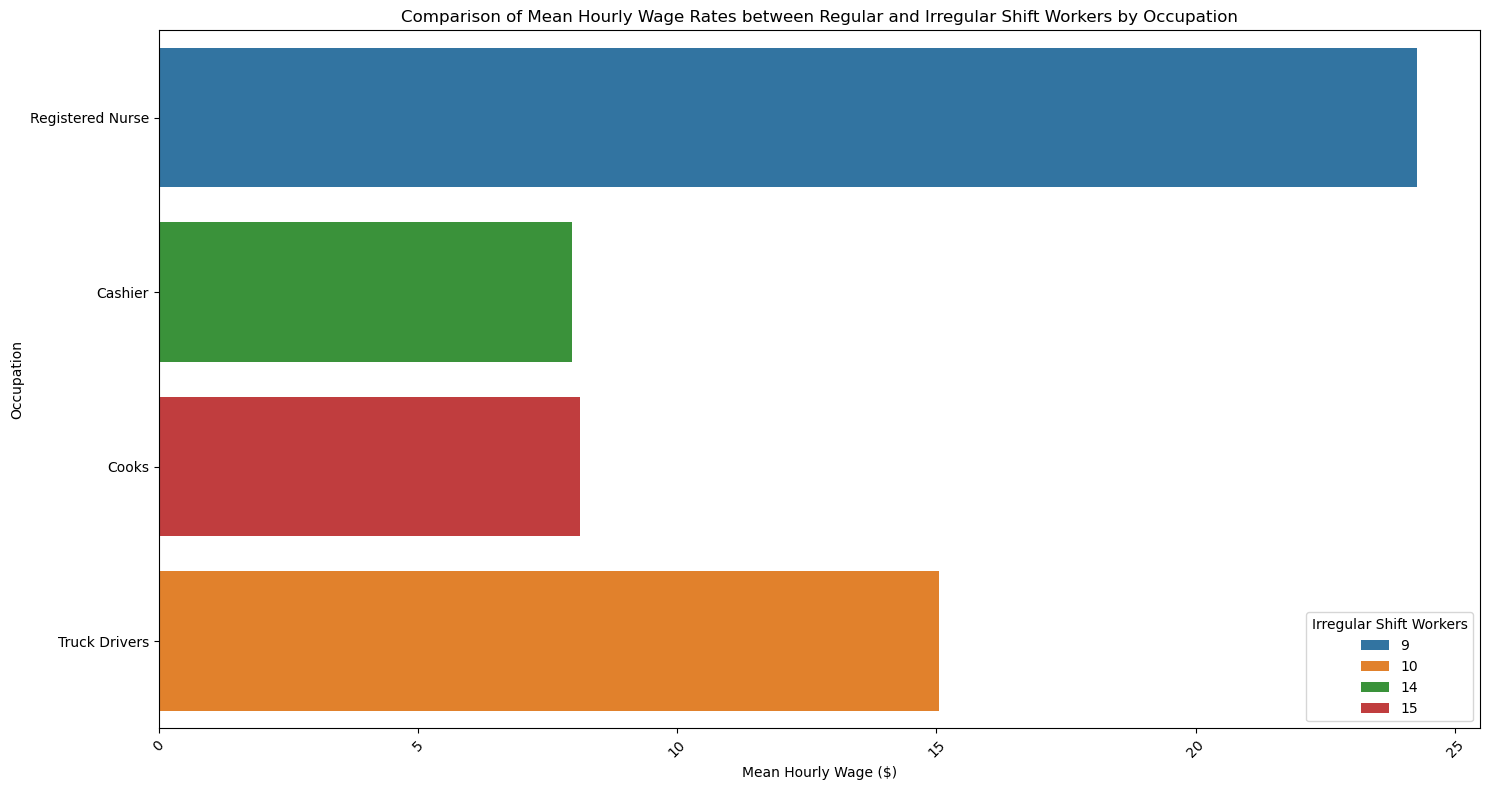

In [7]:
def regular_vs_irregular_shifts_wage(df):
    plt.figure(figsize=(15,8))
    sns.barplot(x='Mean Hourly Wage (Irregular)', y='Occupation', data=df, hue='Irregular Shift Workers', dodge=False)
    plt.xlabel('Mean Hourly Wage ($)')
    plt.ylabel('Occupation')
    plt.title('Comparison of Mean Hourly Wage Rates between Regular and Irregular Shift Workers by Occupation')
    plt.xticks(rotation=45)
    plt.legend(title='Irregular Shift Workers')
    plt.tight_layout()
    plt.show()

regular_vs_irregular_shifts_wage(occupation_df)